# Landuse machine learning model -test-

This notebook integrates the first steps towards the development of a machine learning model for urban landuse prediction.

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import aup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA



from keras import utils                                   # tools for creating one-hot encoding
from keras.models import Sequential                       # Type of model we wish to use
from keras.layers import Dense, Dropout, Activation  
from sklearn.preprocessing import LabelEncoder
# from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras import utils  
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
# from sklearn.pipeline import Pipeline

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,confusion_matrix

2025-07-29 19:20:22.029200: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-29 19:20:22.035911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753838422.043214   75068 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753838422.045333   75068 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753838422.051292   75068 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Data for model training

In [2]:
gdf = gpd.read_file('../../data/processed/prediccion_uso_suelo/complete_model/area_of_prediction_primera_pred.gpkg')
print(gdf.shape)
gdf.head(2)

(680000, 83)


,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,pobtot,...,pct_smote_equipamiento,pct_smote_espacio_verde,pct_smote_habitacional,pct_smote_industria,pct_smote_infraestructura,pct_smote_mixto,pct_smote_otros,pct_smote_servicio,pct_smote_sin_dato,geometry
0,Sin dato,67.279056,75GRMGQW+89PG,1412000011206018,12.438638,278416.454431,67.279056,0.000242,0.184881,0,...,0.001607,0.002559,0.002761,0.001610,0.000106,0.000769,3.047269e-08,0.008672,0.964328,"MULTIPOLYGON (((2349152.724 965335.704, 234914..."
1,Sin dato,45.355545,75GRMGQW+8CFP,1412000011206018,4.482118,278416.454431,45.355545,0.000163,0.098822,0,...,0.005558,0.008587,0.008867,0.003569,0.000371,0.001866,1.236006e-07,0.017841,0.924011,"MULTIPOLYGON (((2349168.91 965335.176, 2349157..."


In [3]:
if 'fid' not in gdf.columns:
    gdf = gdf.reset_index().rename(columns={'index':'fid'})

In [4]:
gdf.columns

Index(['fid', 'uso_suelo', 'area_m2', 'full_plus_code', 'CVEGEO',
       'bld_area_m2', 'block_area_m2', 'pred_area_m2', 'pred_area_pct',
       'bld_pred_area_pct', 'pobtot', 'agropecuario', 'industria', 'servicios',
       'alojamiento', 'comercio', 'cultural_recreativo', 'educacion', 'salud',
       'gobierno', 'otros', 'area_m2_tot', 'habitacional', 'uso_tot',
       'pct_agropecuario', 'pct_industria', 'pct_servicios', 'pct_alojamiento',
       'pct_comercio', 'pct_cultural_recreativo', 'pct_educacion', 'pct_salud',
       'pct_gobierno', 'pct_otros', 'temperature_mean_diff', 'ndvi_mean',
       'ndmi_diff', 'motorway_distance', 'primary_distance',
       'secondary_distance', 'tertiary_distance', 'residential_distance',
       'other_distance', 'denue_primaria', 'denue_primaria_15min',
       'denue_abarrotes', 'denue_abarrotes_15min', 'denue_peluqueria',
       'denue_peluqueria_15min', 'denue_lavanderia', 'denue_lavanderia_15min',
       'clues_primer_nivel', 'clues_primer_nive

## Machine learning model

### Data preprocessing

Divide X and Y data

In [5]:
X = gdf[['bld_area_m2', 'block_area_m2', 'pred_area_m2', 'pred_area_pct',
       'bld_pred_area_pct','area_m2_tot',
        'pobtot', 'agropecuario', 'industria', 'servicios',
       'alojamiento', 'comercio', 'cultural_recreativo', 'educacion', 'salud',
       'gobierno', 'otros',  'habitacional', 
        'uso_tot',
       'pct_agropecuario', 'pct_industria', 'pct_servicios', 'pct_alojamiento',
       'pct_comercio', 'pct_cultural_recreativo', 'pct_educacion', 'pct_salud',
       'pct_gobierno', 'pct_otros', 
        'temperature_mean_diff', 'ndvi_mean',
       'ndmi_diff', 
        'motorway_distance', 'primary_distance',
       'secondary_distance', 'tertiary_distance', 'residential_distance',
       'other_distance', 
        'denue_primaria', 'denue_primaria_15min',
       'denue_abarrotes', 'denue_abarrotes_15min', 'denue_peluqueria',
       'denue_peluqueria_15min', 'denue_lavanderia', 'denue_lavanderia_15min',
       'clues_primer_nivel', 'clues_primer_nivel_15min',
    'pct_pred_agropecuario', 'pct_pred_alojamiento_temporal',
       'pct_pred_area_libre', 'pct_pred_area_natural', 'pct_pred_baldio',
       'pct_pred_comercio', 'pct_pred_equipamiento', 'pct_pred_espacio_verde',
       'pct_pred_habitacional', 'pct_pred_industria',
       'pct_pred_infraestructura', 'pct_pred_mixto', 'pct_pred_otros',
       'pct_pred_servicio', 'pct_pred_sin_dato', 
   'pct_smote_agropecuario',
   'pct_smote_alojamiento_temporal', 'pct_smote_area_libre',
   'pct_smote_area_natural', 'pct_smote_baldio', 'pct_smote_comercio',
   'pct_smote_equipamiento', 'pct_smote_espacio_verde',
   'pct_smote_habitacional', 'pct_smote_industria',
   'pct_smote_infraestructura', 'pct_smote_mixto', 'pct_smote_otros',
   'pct_smote_servicio', 'pct_smote_sin_dato',
    ]].to_numpy()

Y = gdf[['uso_suelo']].to_numpy()
Y = np.reshape(Y, shape=(Y.shape[0],))

Standarize and encode data

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

Divide training, validation and testing data

In [7]:
X_model, X_test, y_model, y_test = (train_test_split(X_scaled, encoded_Y, test_size=0.2, random_state=0))

In [8]:
smote = SMOTE()  
X_resampled, y_resampled = smote.fit_resample(X_model, y_model)  

In [9]:
# X_train, X_val, y_train, y_val = (train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0))
X_train, X_val, y_train, y_val = (train_test_split(X_model, y_model, test_size=0.2, random_state=0))

Y data to categorical

In [10]:
# encode class values as integers
num_classes = len(gdf.uso_suelo.unique())

# convert integers to dummy variables (i.e. one hot encoded)
y_train = utils.to_categorical(y_train, num_classes)

# convert integers to dummy variables (i.e. one hot encoded)
y_val = utils.to_categorical(y_val, num_classes)

# convert integers to dummy variables (i.e. one hot encoded)
y_test = utils.to_categorical(y_test, num_classes)

### Model construction -- Classification Neural network

Model parameters

In [11]:
input_shape = (X_train.shape[1],)

In [12]:
### Construct Keras model

# A sequential model is a linear stack of layers
model = Sequential()

# First layer: fully-connected with relu activation
model.add(Dense(64, input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Second layer: fully-connected with relu activation
model.add(Dense(64))   # Input shape is determined automatically from previous layer
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Third layer: 10 nodes, one for each class, and softmax activation
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Configure the model's training settings
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Print out model summary
print(model.summary())
    

/home/edgaregurrola/.cache/pypoetry/virtualenvs/aup-qDsIK5d5-py3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1753838471.670371   75068 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4483 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         5,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           975 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 15)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,191 (39.81 KB)

 Trainable params: 10,191 (39.81 KB)

 Non-trainable params: 0 (0.00 B)

None


Model training

In [13]:
### Train the model
history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=200,
                    verbose=1,
                    validation_data=(X_val, y_val)
                   )

Epoch 1/200


I0000 00:00:1753838473.333685   75968 service.cc:152] XLA service 0x7fe60c009fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753838473.333700   75968 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-07-29 19:21:13.346464: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753838473.412819   75968 cuda_dnn.cc:529] Loaded cuDNN version 90300


  296/13600 ━━━━━━━━━━━━━━━━━━━━ 6s 510us/step - acc: 0.6281 - loss: 1.5484

I0000 00:00:1753838474.083627   75968 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13600/13600 ━━━━━━━━━━━━━━━━━━━━ 10s 642us/step - acc: 0.7704 - loss: 0.8145 - val_acc: 0.7897 - val_loss: 0.6913
Epoch 2/200
13600/13600 ━━━━━━━━━━━━━━━━━━━━ 8s 597us/step - acc: 0.7839 - loss: 0.7173 - val_acc: 0.7897 - val_loss: 0.6867
Epoch 3/200
13600/13600 ━━━━━━━━━━━━━━━━━━━━ 8s 587us/step - acc: 0.7844 - loss: 0.7093 - val_acc: 0.7886 - val_loss: 0.6872
Epoch 4/200
13600/13600 ━━━━━━━━━━━━━━━━━━━━ 8s 598us/step - acc: 0.7855 - loss: 0.7053 - val_acc: 0.7914 - val_loss: 0.6836
Epoch 5/200
13600/13600 ━━━━━━━━━━━━━━━━━━━━ 8s 597us/step - acc: 0.7860 - loss: 0.7035 - val_acc: 0.7905 - val_loss: 0.6815
Epoch 6/200
13600/13600 ━━━━━━━━━━━━━━━━━━━━ 8s 617us/step - acc: 0.7847 - loss: 0.7032 - val_acc: 0.7915 - val_loss: 0.6803
Epoch 7/200
13600/13600 ━━━━━━━━━━━━━━━━━━━━ 8s 582us/step - acc: 0.7862 - loss: 0.7007 - val_acc: 0.7896 - val_loss: 0.6811
Epoch 8/200
13600/13600 ━━━━━━━━━━━━━━━━━━━━ 8s 600us/step - acc: 0.7867 - loss: 0.6999 - val_acc: 0.7900 - val_loss: 0.6830
Epoch 9/200

Evaluate model

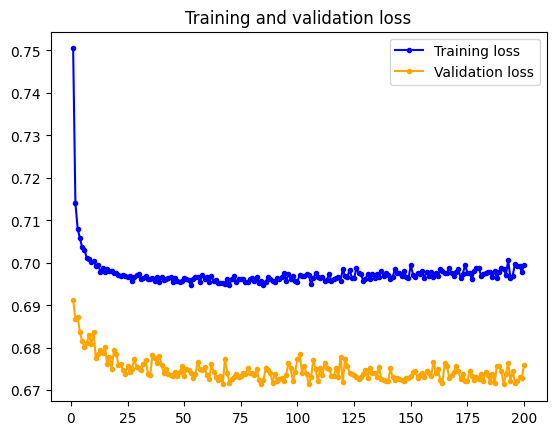

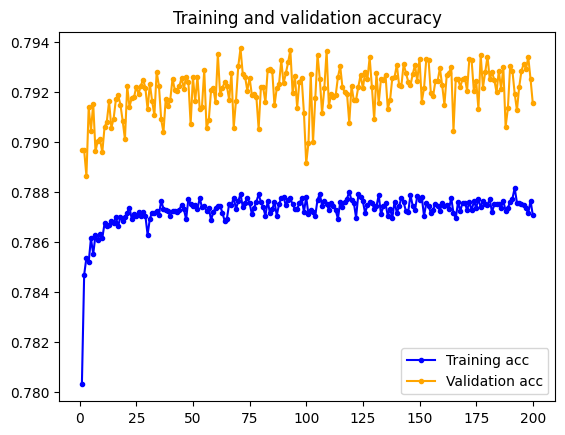

In [14]:
### Plot training and validation accuracy and loss over time

# Extract accuracy and loss values (in list form) from the history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a list of epoch numbers
epochs = range(1, len(acc) + 1)

# Plot training and validation loss values over time
plt.figure()
plt.plot(epochs, loss, color='blue', marker='.', label='Training loss')
plt.plot(epochs, val_loss, color='orange', marker='.', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Plot training and validation accuracies over time
plt.figure()
plt.plot(epochs, acc, color='blue', marker='.', label='Training acc')
plt.plot(epochs, val_acc, color='orange', marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [15]:
### Create confusion matrix from validation set

# Find predictions from all validation samples
y_pred = model.predict(X_val)
print("Validation output shape:", y_pred.shape)

# Convert actual and predicted validation one-hot encoding to numerical labels
y_val_trans = np.argmax(y_val, axis=1)
y_pred_trans = np.argmax(y_pred, axis=1)

# Print some values from actual and predicted validation sets (first 50 samples)
print("Actual validation labels:\t", y_val_trans[:50])
print("Predicted validation labels:\t", y_pred_trans[:50])

# Compute confusion matrix (note: we need to transpose SKLearn matrix to make it match Edge Impulse)
cm = confusion_matrix(y_val_trans, y_pred_trans)
cm = np.transpose(cm)

labels = range(len(gdf['uso_suelo'].unique()))

# Print confusion matrix
print()
print(" ---> Predicted labels")
print("|")
print("v Actual labels")
print("\t\t\t" + ' '.join("{!s:6}".format('(' + str(i) + ')') for i in range(num_classes)))
for row in range(num_classes):
  print("{:>12} ({}):  [{}]".format(labels[row], row, ' '.join("{:6}".format(i) for i in cm[row])))
    

3400/3400 ━━━━━━━━━━━━━━━━━━━━ 1s 286us/step
Validation output shape: (108800, 15)
Actual validation labels:	 [ 8  8  8 13  8  8  8  8  8  8  8  8  4  8 10  8  8  8  8  8  8  8 14  8
  5  8  8  8  8  6  8  8  8  8  4  4  8  8  9  8  8  8  8  8  4  8  8  8
  8  7]
Predicted validation labels:	 [ 8  8  8  8  8  8  8  8  8  8  8  8  8  4 10  8  8  8  8  8  8  8  8  8
 13  8  8  8  8  6  8  8  8  8  8  4  8  8  8  8  8  8  8  8  4  8  4  8
  8  4]

 ---> Predicted labels
|
v Actual labels
			(0)    (1)    (2)    (3)    (4)    (5)    (6)    (7)    (8)    (9)    (10)   (11)   (12)   (13)   (14)  
           0 (0):  [   743      0      0      0    186     14      5     14     84     16      2      2      1     11      5]
           1 (1):  [     1     72      0      0      4      7      3      0     14      7      0      2      1     21      0]
           2 (2):  [     2      0    115      0     35      1      3     10     35      5      0      0      3      6      0]
           3 (3):  [    

## Apply model to the full dataset

Predict landuse for every element

In [16]:
y_hat = model.predict(X_scaled)

21250/21250 ━━━━━━━━━━━━━━━━━━━━ 6s 278us/step


Create prediction variables

Assign data to polygons

In [17]:
gdf['pred'] = y_hat.argmax(axis=1)

### Save output

### Save model

In [18]:
import pickle

In [19]:
model_name = 'landuse_nn_PredictionModel'
pickle.dump(model, open(f"../../data/processed/prediccion_uso_suelo/complete_model/{model_name}.pkl", "wb"))

### Save data for postprocessing

In [38]:
# gdf.to_file('../../data/processed/prediccion_uso_suelo/test/tess_pred.gpkg')

### Save data for output analysis

In [20]:
gdf[['fid','uso_suelo','pred','geometry']].to_file('../../data/processed/prediccion_uso_suelo/complete_model/area_of_prediction_final_pred.gpkg')